### *План исследования:*

- ***1. Загрузка данных, изучение общей информации*** 

 - [Загрузка библиотек, файлов с данными, ознакомление, получение общей информации](#Link1)


- ***2. Предобработка данных***

 - [Ресемплирование данных](#Link2)
 
 
- ***3. Исследовательский анализ данных***

 - [Изучение аномалий, выбросов и распределений целевого признака. Построение графиков временного ряда, тренда, сезонности](#Link3)
 - [Проверка ряда на стационарность](#Link4)
 - [Изучение автокорреляций ряда](#Link5)
 - [Дифференцирование ряда](#Link6)


- ***4. Подготовка признаков для построения моделей***

 - [Создание новых признаков](#Link7)
 - [Разделение датасета на обучающую и тестовую выборки](#Link8)
 

- ***5. Построение моделей***

 - [Линейная регрессия](#Link9)
 - [Дерево решений](#Link10)
 - [Случайный лес](#Link11)
 - [Градиентный бустинг](#Link12)
 
 
- ***6. Анализ моделей*** 

 - [Проверка моделей на тестовой выборке](#Link13)
 - [Проверка моделей на вменяемость](#Link14)


- ***7.  Выбор лучшей модели. Анализ остатков лучшей модели***

 - [Анализ остатков лучшей модели](#Link15)
 
 
- ***8. Дальнейшее прогнозирование ряда***

 - [Прогноз](#Link16)
 
 
- ***9. Общий вывод***
 - [Вывод](#Link17)

## 1. Загрузка данных, изучение общей информации

<a id='Link1'></a>

### Загрузка библиотек, файлов с данными, ознакомление, получение общей информации

In [1]:
from IPython.display import display
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats as st

In [2]:
# параметры чтения файла
params_read = {'index_col': 'datetime',
               'parse_dates': ['datetime']}

# читаем файл с данными
taxi = pd.read_csv(r'Data\taxi.csv', **params_read)

print('\nИнфо по датасету taxi: \n')
display(taxi.info())
print('\nДатасет taxi: \n')
display(taxi.head(5))


Инфо по датасету taxi: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Датасет taxi: 



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Вывод
 - При чтении файла сразу в качестве индекса установили столбец `datetime`
 - Данные соответствуют описанию: переда нами временной ряд, количество заказов такси находится в столбце `num_orders`
 - В датасете 1 столбец, 26496 строк
 - Видим, что величина количества заказов фиксируется каждые 10 минут
 - *Пропуски не наблюдаем*
 - *Названия столбцов удобные*
 - *Типы данных соотвествуют данным в столбцах*
 - **Целевой признак, который нужно будет прогнозировать:**
    - Количество заказов такси **`num_orders`**
 - **Горизонт прогнозирования - 1 час**

## 2. Предобработка данных

<a id='Link2'></a>

### Отсортируем временной ряд по индексу и проведем ресемплирование данных с шагом в 1 час

In [3]:
# сортируем по индексу
taxi = taxi.sort_index()

print('\nИсторические данные за период: с {:%d.%m.%Y} по {:%d.%m.%Y}\n'
      .format(taxi.index.min(), taxi.index.max()))

print('Датасет до ресемплирования:')
display(taxi.head(6))

# делаем ресемплирование в 1 час
taxi = taxi.resample('1H').sum()

print('\nДатасет после ресемплирования:')
display(taxi.head(2))


Исторические данные за период: с 01.03.2018 по 31.08.2018

Датасет до ресемплирования:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21



Датасет после ресемплирования:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85


### Вывод
 - Отсортировали временной ряд по индексу и провели ресемплирование данных с шагом в 1 час

## 3. Исследовательский анализ данных

In [4]:
def fun_adfuller(time_series, title):
    """
    функция для проверки стационарности ряда
    по критерию Дики-Фуллера
    
    """

    alpha = 0.05
    # тест Дики-Фуллера
    stat = sm.tsa.stattools.adfuller(time_series)[0]
    p = sm.tsa.stattools.adfuller(time_series)[1]
    print('H0: Ряд нестационарен')
    print('H1: Ряд стационарен\n')    
    print('Критерий Дики-Фуллера для ряда', title)
    print('statistic=%.3f, p=%.7f' % (stat, p))
    
    if p < alpha:
        print('\nОтклоняем H0. Принимаем H1:\nРяд стационарен')
    else:
        print('\nУ нас недостаточно оснований отклонить H0:\nРяд нестационарен')    

In [5]:
def fun_ttest(x, title):
    """
    функция для проверки равенства среднего ГС нулю
    по критерию t-Стьюдента
    
    """

    alpha = 0.05
    # T-тест
    stat, p = st.ttest_1samp(x, 0)
    print('H0: Среднее ГС, из которой взята выборка, равно 0')
    print('H1: Среднее ГС, из которой взята выборка, НЕ равно 0\n')    
    print('Критерий t-Стьюдента для выборки', title)
    print('statistic=%.3f, p=%.7f' % (stat, p))
    
    if p < alpha:
        print('\nОтклоняем H0. Принимаем H1:\nСреднее ГС, из которой взята выборка, НЕ равно 0')
    else:
        print('\nУ нас недостаточно оснований отклонить H0:\nСреднее ГС, из которой взята выборка, равно 0')

<a id='Link3'></a>

### Изучение аномалий, выбросов и распределений целевого признака. Построение графиков временного ряда, тренда, сезонности

In [6]:
# получаем объект Decompose_Result для изучения тренда, сезонности
decomposed_taxi = seasonal_decompose(taxi)

In [7]:
def fun_ax(ax, plot, x, title, y=None,
           x_label=None, y_label=None,
           color=None, label=None,
           xtick_location=None):
    """ функция для рисования plt.subplots
    
    параметры:
     - subplot
     - тип графика
     - выборка для оси X
     - заголовок
     - выборка для оси Y
     - название для оси Х
     - название для оси Y
     - цвет
     - название для легенды
     - локации точки по оси X
    """
    
    # boxplot
    if plot == 'box':
        ax.boxplot(x, vert=False)

    # гистограмма
    elif plot == 'hist':
        ax.hist(x, color=color, histtype='stepfilled',
                bins=round(len(x) ** 0.5), rwidth=0.05, alpha=0.5)
    
    # если bar
    elif plot == 'bar':
        ax.bar(x, y, color=color)        
    
    # линейный график
    elif plot == 'plot':
        ax.plot(x, color=color, label=label)
        ax.legend()
        
    # скаттер-плот
    elif plot == 'scatter':
        ax.scatter(x, y, s=1, c=color)   
    
    # заголовок, названия осей
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    # выводим xticks
    try:
        ax.set_xticks(xtick_location)    
    except: None
        
    return None

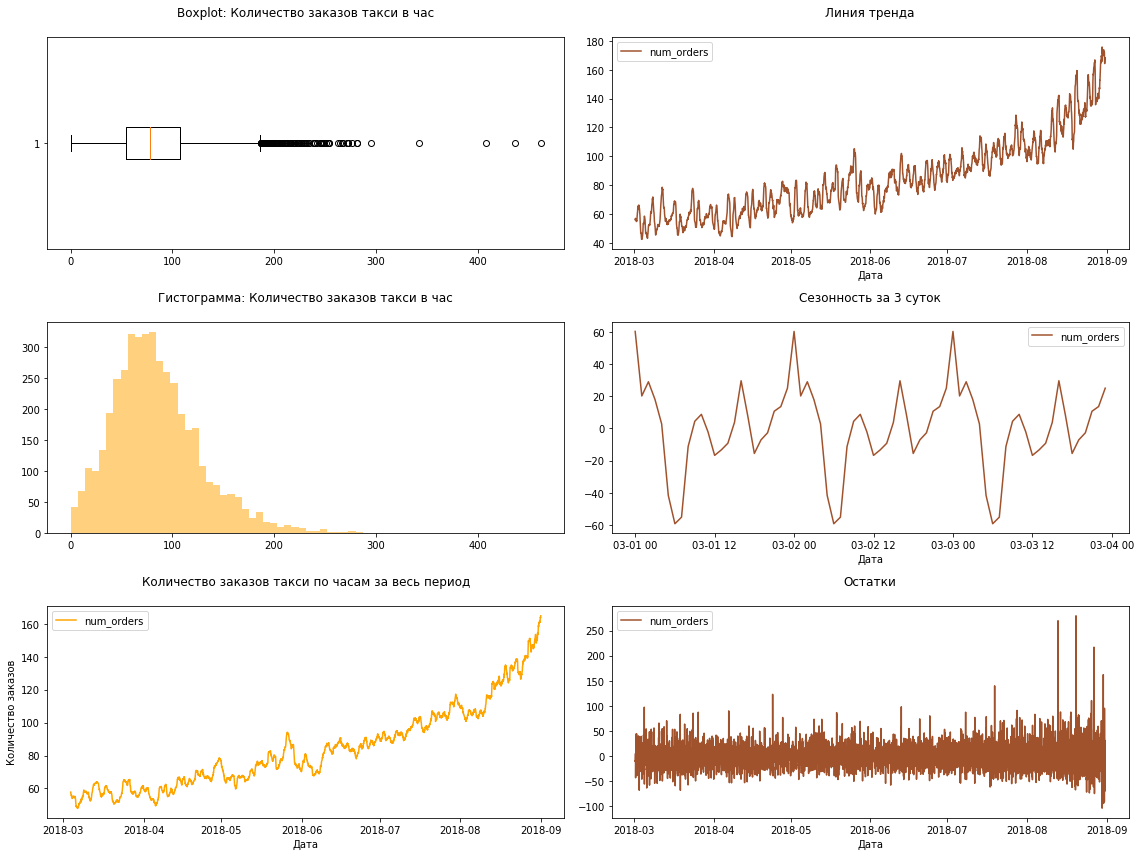

In [8]:
fig = plt.figure(figsize=(16,12))

ax1 = plt.subplot2grid((3,2), (0,0))
ax2 = plt.subplot2grid((3,2), (1,0))
ax3 = plt.subplot2grid((3,2), (2,0))
ax4 = plt.subplot2grid((3,2), (0,1))
ax5 = plt.subplot2grid((3,2), (1,1))
ax6 = plt.subplot2grid((3,2), (2,1))

# boxplot num_orders
fun_ax(ax1, 'box', taxi.num_orders,
       'Boxplot: Количество заказов такси в час\n')

# гистограмм num_orders
fun_ax(ax2, 'hist', taxi.num_orders,
       'Гистограмма: Количество заказов такси в час\n',
       color='orange')

# линейный график num_orders
# для сглаживания используем скользящее окно размером 72 часа
fun_ax(ax3, 'plot', taxi.num_orders.rolling(72).mean(),
       'Количество заказов такси по часам за весь период\n',
       x_label='Дата', y_label='Количество заказов',
       color='orange', label='num_orders')

# линейный график для линии тренда
fun_ax(ax4, 'plot', decomposed_taxi.trend,
       'Линия тренда\n', x_label='Дата',
       color='sienna', label='num_orders')

# линейный график для сезонности
# для наглядности возьмём 3 дня
fun_ax(ax5, 'plot', decomposed_taxi.seasonal['2018-03-01':'2018-03-03'],
       'Сезонность за 3 суток\n', x_label='Дата',
       color='sienna', label='num_orders')

# линейный график для остатков
fun_ax(ax6, 'plot', decomposed_taxi.resid,
       'Остатки\n', x_label='Дата',
       color='sienna', label='num_orders')

fig.tight_layout()

- Посчитаем уровни q3+1.5iqr и q3+3iqr, с которого начинаются грубые выбросы

In [9]:
# считаем q3+1.5iqr
print('\nУровень выбросов q3+1.5iqr: ', taxi.num_orders.quantile(0.75) + 1.5 * \
                          (taxi.num_orders.quantile(0.75) - \
                           taxi.num_orders.quantile(0.25)))
# считаем q3+3iqr
print('\nУровень грубых выбросов q3+3iqr: ', taxi.num_orders.quantile(0.75) + 3 * \
                          (taxi.num_orders.quantile(0.75) - \
                           taxi.num_orders.quantile(0.25)))


Уровень выбросов q3+1.5iqr:  186.5

Уровень грубых выбросов q3+3iqr:  266.0


### Вывод
- Наблюдаем выбросы, начиная со значения *186 заказов в час*. Будем считать, что *пиковая нагрузка приходится на этот уровень и выше*
- Наблюдаем грубые выбросы, начиная со значения 266 заказов в час
- *Распределение* признака `num_orders` похоже на нормальное, но *скошено вправо*, что подтверждает наличие выбросов
- Отметим, что *с марта 2018 по сентябрь 2018 количество заказов в час постепенно увеличивалось*. Видим **восходящую линию тренда**
- Видим, что **каждую ночь до раннего утра количество заказов такси падает, больше всего заказов вечером**
- Остатки похожи на шумы

<a id='Link4'></a>

### Проверим, является ли ряд стационарным, с помощью критерия Дики-Фуллера

In [10]:
# считаем критерий Дики-Фуллера
fun_adfuller(taxi.num_orders, 'Исходный ряд num_orders')

H0: Ряд нестационарен
H1: Ряд стационарен

Критерий Дики-Фуллера для ряда Исходный ряд num_orders
statistic=-3.069, p=0.0289401

Отклоняем H0. Принимаем H1:
Ряд стационарен


### Вывод:
 - C помощью критерия Дики-Фуллера по исходному ряду получили значение p=0.0289401. **Мы отклонили H0 о нестационарности ряда**
 - **Посмотрим на автокорреляции ряда**

<a id='Link5'></a>

### Изучим корреляцию ряда с лагом корреляции 1 час, 12 часов, 24 часа

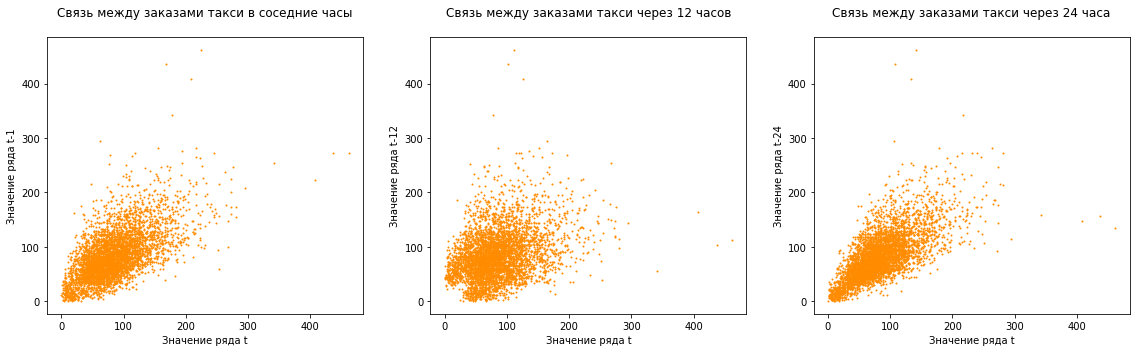

In [11]:
fig = plt.figure(figsize=(16,5))

# график зависимости между соседними часами
ax = plt.subplot(131)
fun_ax(ax, 'scatter',
       taxi.num_orders,
       'Связь между заказами такси в соседние часы\n',
       y=taxi.num_orders.shift(1),
       x_label='Значение ряда t',
       y_label='Значение ряда t-1',
       color='darkorange')

# график зависимости между часами с лагом в 12 часов
ax = plt.subplot(132)
fun_ax(ax, 'scatter',
       taxi.num_orders,
       'Связь между заказами такси через 12 часов\n',
       y=taxi.num_orders.shift(12),
       x_label='Значение ряда t',
       y_label='Значение ряда t-12',
       color='darkorange')

# график зависимости между часами с лагом в 24 часа
ax = plt.subplot(133)
fun_ax(ax, 'scatter',
       taxi.num_orders,
       'Связь между заказами такси через 24 часа\n',
       y=taxi.num_orders.shift(24),
       x_label='Значение ряда t',
       y_label='Значение ряда t-24',
       color='darkorange')

fig.tight_layout()

### Вывод:
- Наблюдаем высокую корреляцию между заказами такси с лагом в 24 часа (что ещё раз подтверждает суточную сезонность) и между соседними часами. Отдельные точки вне основного облака говорят о резком подъеме заказов ночью и резком падении утром
- Корреляция между заказами через 12 часов не так ярко выражена, облако точек более рассеяно

### Посмотрим на автокорреляционную функцию, построим коррелограмму

In [12]:
def fun_acf_pcf(ax, time_series, lags, type_cf, title=None):
    """ функция для построения коррелограммы:
    автокорреляционной функции и 
    частной автокорреляционной функции
    
    """
    
    # автокорреляционная функция
    if type_cf == 'acf':
        sm.graphics.tsa.plot_acf(time_series.squeeze(), lags=lags, ax=ax, title=title)
    # частная автокорреляционная функция
    elif type_cf == 'pacf':
        sm.graphics.tsa.plot_pacf(time_series.squeeze(), lags=lags, ax=ax, title='Частная автокорреляционная функция')

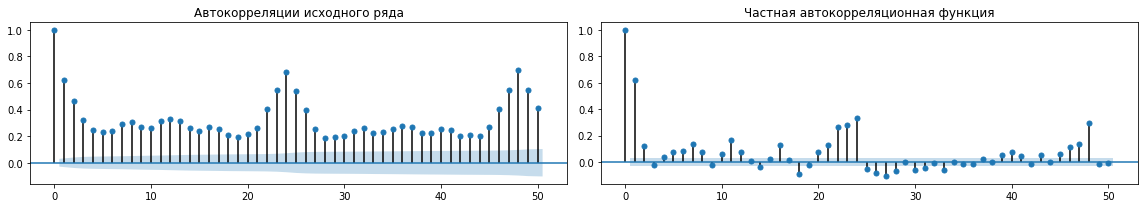

In [13]:
# рисуем коррелограммы
fig = plt.figure(figsize=(16,3))

# ACF
ax = plt.subplot(121)
fun_acf_pcf(ax, taxi.num_orders.values, 50, 'acf', 'Автокорреляции исходного ряда')

# PACF
ax = plt.subplot(122)
fun_acf_pcf(ax, taxi.num_orders.values, 50, 'pacf')

fig.tight_layout()

### Вывод:
 - Наблюдаем пики на лагах, кратных сезонному периоду (24, 48), а также с соседним значением ряда.
 - На графике видим много значимых лагов, все наши автокорреляции значимо отличаются от нуля (выходят за пределы синего коридора)

<a id='Link6'></a>

### Продифференцируем ряд: перейдем к попарным разностям его значений в соседних сезонах

In [14]:
# сезонный лаг в 24 часа
DIFF_LAG = 24

# создаем столбец с сезонными разностями
taxi['num_orders_diff'] = taxi.num_orders - taxi.num_orders.shift(DIFF_LAG)

print('\nДатасет с новым столбцом num_orders_diff попарных сезонных разностей:')
display(taxi[['num_orders', 'num_orders_diff']].head(30))


Датасет с новым столбцом num_orders_diff попарных сезонных разностей:


,num_orders,num_orders_diff
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
2018-03-01 05:00:00,6,NaN
2018-03-01 06:00:00,12,NaN
2018-03-01 07:00:00,15,NaN
2018-03-01 08:00:00,34,NaN


### Проверим дифференцированный ряд на стационарность с помощью критерия Дики-Фуллера и построим кореллограммы

In [15]:
# критерий Дики-Фуллера
fun_adfuller(taxi.num_orders_diff[DIFF_LAG:], 'Дифференцированный ряд')

H0: Ряд нестационарен
H1: Ряд стационарен

Критерий Дики-Фуллера для ряда Дифференцированный ряд
statistic=-16.006, p=0.0000000

Отклоняем H0. Принимаем H1:
Ряд стационарен


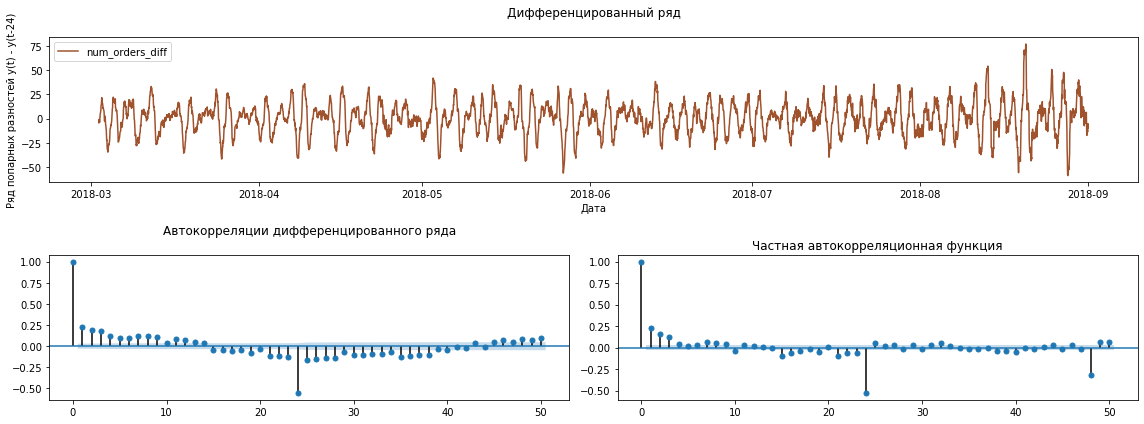

In [16]:
fig = plt.figure(figsize=(16,6))

# линейный график попарных сезонных разностей
ax = plt.subplot2grid((2,2), (0,0), colspan=2)
fun_ax(ax, 'plot',
        taxi.num_orders_diff[DIFF_LAG:].rolling(12).mean(),
        'Дифференцированный ряд\n',
        x_label='Дата',
        y_label='Ряд попарныx разностей y(t) - y(t-{})'.format(DIFF_LAG),
        color='sienna', label='num_orders_diff')

# ACF
ax = plt.subplot2grid((2,2), (1,0))
fun_acf_pcf(ax, taxi.num_orders_diff[DIFF_LAG:], 50, 'acf', 'Автокорреляции дифференцированного ряда\n')

# PACF
ax = plt.subplot2grid((2,2), (1,1))
fun_acf_pcf(ax, taxi.num_orders_diff[DIFF_LAG:].values, 50, 'pacf')

fig.tight_layout()

# сохраняем значения автокорреляций
q_test = sm.tsa.stattools.acf(taxi.num_orders_diff[DIFF_LAG:], qstat=True) 

### Проверим, равны ли автокорреляции в среднем нулю. Для проверки равенства среднего нулю здесь и далее будем использовать t-критерий Стьюдента, так как объем исследуемых выборок будет больше 30 (n > 30), и, значит, t_test даст результат, даже если распределение выборок будет отличным от нормального

In [17]:
# t-test на равенство среднего нулю
fun_ttest(q_test[0], 'Автокорреляции дифференцированного ряда')

H0: Среднее ГС, из которой взята выборка, равно 0
H1: Среднее ГС, из которой взята выборка, НЕ равно 0

Критерий t-Стьюдента для выборки Автокорреляции дифференцированного ряда
statistic=-0.252, p=0.8021551

У нас недостаточно оснований отклонить H0:
Среднее ГС, из которой взята выборка, равно 0


### Вывод:
 - **Продифференцировали ряд на сезонный период**
 - Избавились от тренда
 - Посчитали критерий Дики-Фуллера по диференцированному ряду, получили p=0.0000000. **Ряд стационарен**
 - Построили коррелограммы, значимых лагов не обнуражили. Проверили автокорреляции на равенство среднего нулю с помощью критерия t-Стьюдента, получили p=0.8021551. **В среднем автокорреляции дифференцированного ряда равны нулю, то есть полученный ряд неавтокоррелирован**

## 4. Подготовка признаков для построения моделей

<a id='Link7'></a>

### Создание новых признаков

- *Календарные признаки*: `hour` и `dayofweek`
- *Отстающие значения*: так как в течение суток у нас наблюдается "сезонность", то есть периодический спад и подъем, то возьмем лаги за последние сутки (24 часа)
- *Скользящее среднее*: возьмем скользящее среднее за последние 3 часа

In [18]:
def fun_create_features_new_row(df, max_lag, rol_mean_size, time_label):
    """ функция для создания признаков для одной строки с новым часом
    для прогнозирования на несколько часов вперед за пределами
    тестовой выборки
    
    параметры:
     - dataframe
     - max лаг
     - размер скользящего окна
     - time_label (тип datetime)

    возвращает строку с новыми признаками и с label = time_label
    """    
    
    # добавляем названия столбцов для календарных признаков
    columns_list= ['hour', 'dayofweek']
    # добавляем значения часа и дня недели
    new_row_list = [time_label.hour,
                    time_label.dayofweek]
    
    # отстающие значения
    for lag in range(1, max_lag + 1):
        # добавляем названия для столбцов с лагами
        columns_list.append('lag_{}'.format(lag))
        # добавляем значения ряда с отстающим лагом
        new_row_list.append(df.iloc[-lag]['num_orders_diff'])

    # скользящее среднее
    # добавляем название для столбца со скользящим средним
    columns_list.append('rolling_mean')
    # добавляем значение скользщего среднего
    # берем среднее rol_mean_size последних элементов ряда
    new_row_list.append(df[-rol_mean_size:].num_orders_diff.mean())

    return pd.Series(new_row_list, index=columns_list)

In [19]:
def fun_create_features(df, max_lag, rol_mean_size):
    """ функция для создания признаков для датасета
    
    параметры:
     - dataframe
     - max лаг
     - размер скользящего окна

    возвращает dataframe с новыми признаками
    """    
    
    # календарные признаки
    # час
    df['hour'] = df.index.hour
    # день недели
    df['dayofweek'] = df.index.dayofweek

    # отстающие значения
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df.num_orders_diff.shift(lag)

    # скользящее среднее по rol_mean_size последним значениям ряда
    df['rolling_mean'] = df.num_orders_diff.shift(1).rolling(rol_mean_size).mean()
    
    return df

In [20]:
# задаем максимальны лаг
MAX_LAG = 24
# задаем размер скользящего окна
ROL_SIZE = 3

# создаем новые признаки для построения моделей
taxi = fun_create_features(taxi, MAX_LAG, ROL_SIZE)
print('Датасет после создания новых признаков:')
display(taxi[DIFF_LAG:].head())

Датасет после создания новых признаков:


,num_orders,num_orders_diff,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,-34.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 01:00:00,120,35.0,1,4,-34.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 02:00:00,75,4.0,2,4,35.0,-34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 03:00:00,64,-2.0,3,4,4.0,35.0,-34.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.666667
2018-03-02 04:00:00,20,-23.0,4,4,-2.0,4.0,35.0,-34.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.333333


<a id='Link8'></a>

### Разделим датасет на обучающую и тестовую (10% от исходных данных) выборки

In [21]:
# делаем сплит на train и test
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

# проверяем индексы train и test
print('Обучающая выборка: Индекс min - {}, Индекс max - {}'.format(train.index.min(), train.index.max()))
print('Тестовая выборка: Индекс min - {}, Индекс max - {}\n'.format(test.index.min(), test.index.max()))
print('Длина обучающей выборки: {}'.format(train.shape[0]))
print('Длина тестовой выборки: {}\n'.format(test.shape[0]))
print('В обучающей выборке удалим строки с пропусками:')
display(train.isnull().sum())

# в обучающей выборке удаляем строки с NaN
train = train.dropna(axis=0)

print('Длина обучающей выборки после удаления пропусков: {}'.format(train.shape[0]))
print('Длина тестовой выборки: {}'.format(test.shape[0]))

Обучающая выборка: Индекс min - 2018-03-01 00:00:00, Индекс max - 2018-08-13 13:00:00
Тестовая выборка: Индекс min - 2018-08-13 14:00:00, Индекс max - 2018-08-31 23:00:00

Длина обучающей выборки: 3974
Длина тестовой выборки: 442

В обучающей выборке удалим строки с пропусками:


num_orders          0
num_orders_diff    24
hour                0
dayofweek           0
lag_1              25
lag_2              26
lag_3              27
lag_4              28
lag_5              29
lag_6              30
lag_7              31
lag_8              32
lag_9              33
lag_10             34
lag_11             35
lag_12             36
lag_13             37
lag_14             38
lag_15             39
lag_16             40
lag_17             41
lag_18             42
lag_19             43
lag_20             44
lag_21             45
lag_22             46
lag_23             47
lag_24             48
rolling_mean       27
dtype: int64

Длина обучающей выборки после удаления пропусков: 3926
Длина тестовой выборки: 442


### Целевой признак для моделей - ряд попарных сезонных разностей `num_orders_diff` (дифференцированный ряд `num_orders` на сезонный лаг)

In [22]:
# сохраним фичи для train и test
train_features = train.drop(['num_orders', 'num_orders_diff'], axis=1)
test_features = test.drop(['num_orders', 'num_orders_diff'], axis=1)

# для обучения моделей будем использовать целевой признак:
# ряд попарных сезонных разностей num_orders_diff (дифференцированный ряд num_orders)
train_target_diff = train['num_orders_diff']

# для константных моделей будем использовать исходное значение ряда num_orders
train_target_base = train['num_orders']

# целевой признак тестовой выборки - исходное значение ряда num_orders
test_target = test['num_orders']

### Вывод
 - Создали новые признаки для обучения моделей
 - Разделили датасет на обучающую и тестовую выборки
 - Выделили фичи и целевой признак в выборках train и test

## 5. Построение моделей

In [23]:
# функция для расчета RMSE
fun_rmse = lambda target, predictions: \
           mean_squared_error(np.array(target), predictions) ** 0.5

# задаем свой score через функцию
score_rmse = make_scorer(fun_rmse,
                         greater_is_better=False)

In [24]:
def fun_build_model(model, model_name, parametrs, features, target, cv, params_fit):
    """функция для построения модели,
    обучает модель, подбирает лучшие параметры,
    использует кросс-валидацию и скор = score_rmse
    
    параметры:
     - структура модели
     - наименование
     - словарь параметров, по которым нужно определить лучшую модель
     - список фичей
     - таргет
     - кол-во сплитов при кросс-валидации
     - параметры для обучения
    
    возвращает результат работы метода GridSearchCV
    """
    
    # передаем модель и параметры
    grid= GridSearchCV(model, parametrs, scoring=score_rmse, n_jobs=-1,
                       cv=TimeSeriesSplit(n_splits=cv))
    
    # обучаем модель
    grid.fit(features, target, **params_fit)

    # выводим лучшую модель, лучшие параметры и лучший скор
    print('Лучшая модель {}:'.format(model_name))
    display(grid.best_estimator_)
    print('Лучшие параметры модели:')
    display(grid.best_params_)
    print('Лучший RMSE: {}\n'.format(grid.best_score_.round(2)))
    
    print('Время обучения полного обучающего датасета после получения лучших параметров: {:.3f} сек\n'
      .format(grid.refit_time_))
    
    # возвращаем grid
    return grid

In [25]:
def features_importances(model, col_names, model_name):
    """функция для вывода весов признаков при построении модели
    
    на входе:
     - модель
    
    на выходе:
     - вывод весов признаков
    """
    # создаем DF из feature_importances модели
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({'features': col_names, 'feature_importances': feature_importances})

    # рисуем bar
    fig = plt.figure(figsize=(18,4))
    ax = plt.subplot(111)
    fun_ax(ax, 'bar',
           feature_importances_df.sort_values('feature_importances', ascending=False).features,
          'Веса признаков при построении модели {}'.format(model_name),           
           feature_importances_df.sort_values('feature_importances', ascending=False).feature_importances,
           x_label='Признаки', y_label='Веса',
           color='orange')
    plt.xticks(rotation=45)
    fig.tight_layout()

<a id='Link9'></a>

### Модель Линейная регрессия

In [26]:
# формируем параметры для поиска лучшей модели
params_grid = {'normalize': [True, False]}

# строим модель Линейная регрессия
grid_linear_regression = fun_build_model(LinearRegression(),
                                         'Линейная регрессия',
                                         params_grid,
                                         train_features, train_target_diff, cv=3, params_fit={})

Лучшая модель Линейная регрессия:


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

Лучшие параметры модели:


{'normalize': True}

Лучший RMSE: -26.78

Время обучения полного обучающего датасета после получения лучших параметров: 0.019 сек



<a id='Link10'></a>

### Модель Дерево решений

Лучшая модель Дерево решений:


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=46, min_samples_split=102,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=12345, splitter='best')

Лучшие параметры модели:


{'max_depth': 9, 'min_samples_leaf': 46, 'min_samples_split': 102}

Лучший RMSE: -27.69

Время обучения полного обучающего датасета после получения лучших параметров: 0.031 сек



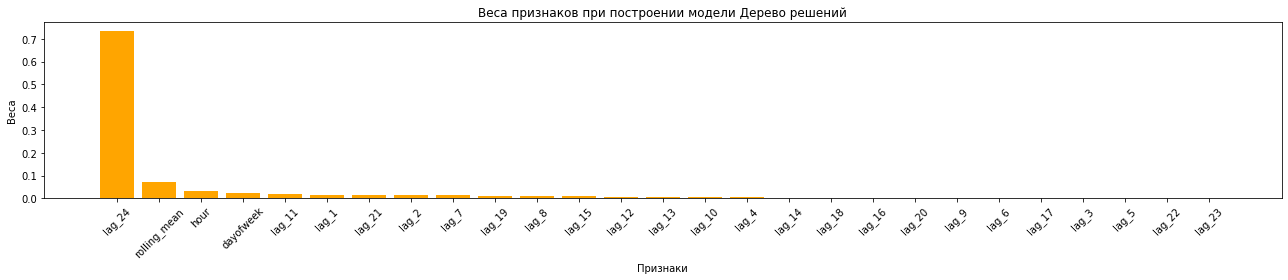

In [27]:
# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,22,2),
               'min_samples_split': range(2,103,10),
               'min_samples_leaf': range(1,62,5)}

# строим модель Дерево решений
grid_tree_regressor = fun_build_model(DecisionTreeRegressor(random_state=12345),
                                      'Дерево решений',
                                      params_grid,
                                      train_features, train_target_diff, cv=3, params_fit={})

# смотрим веса признаков при построении модели
features_importances(grid_tree_regressor.best_estimator_,
                     train_features.columns,
                     'Дерево решений')

<a id='Link11'></a>

### Модель Случайный лес

Лучшая модель Случайный лес:


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=11, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

Лучшие параметры модели:


{'max_depth': 11, 'n_estimators': 50}

Лучший RMSE: -26.38

Время обучения полного обучающего датасета после получения лучших параметров: 1.953 сек



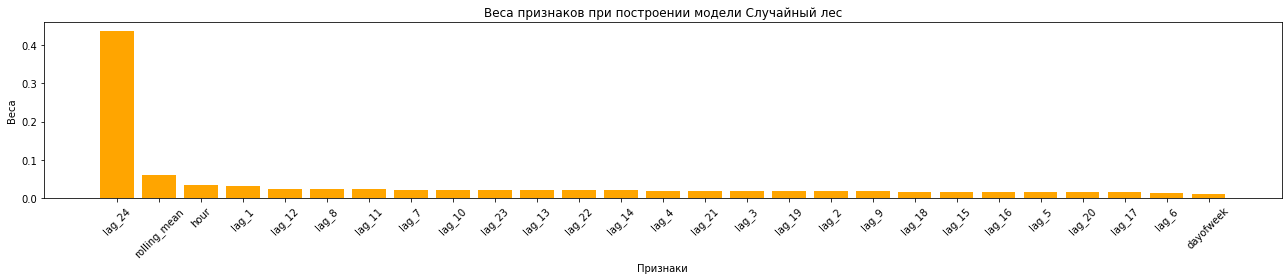

In [28]:
# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,20,2),
               'n_estimators': range(10,51,10)}

# строим модель Случайный лес
grid_forest_regressor = fun_build_model(RandomForestRegressor(random_state=12345),
                                        'Случайный лес',
                                        params_grid,
                                        train_features, train_target_diff, cv=3, params_fit={})

# смотрим веса признаков при построении модели
features_importances(grid_forest_regressor.best_estimator_,
                     train_features.columns,
                     'Случайный лес')

<a id='Link12'></a>

### Модель Градиентный бустинг

Лучшая модель Градиентный бустинг:


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=11,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=20, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Лучшие параметры модели:


{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 50}

Лучший RMSE: -26.27

Время обучения полного обучающего датасета после получения лучших параметров: 0.060 сек



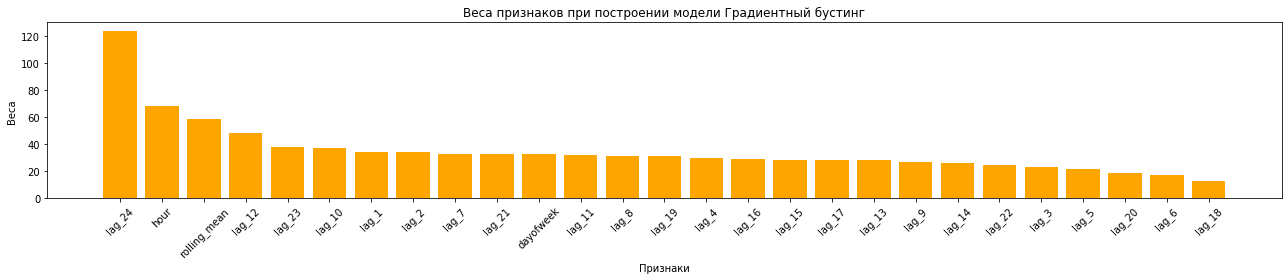

In [29]:
# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,12,2),
               'learning_rate': np.arange(0.1,1.0,0.1),
               'n_estimators': range(10, 101, 10)}

# формируем параметры для создания модели
params_model = {'num_leaves': 20,
                'random_state': 12345}
    
# задаем модель LGBMRegressor
model_lgb = lgb.LGBMRegressor(**params_model)

# строим модель Градиентный бустинг
grid_lgb = fun_build_model(model_lgb,
                           'Градиентный бустинг',
                           params_grid,
                           train_features, train_target_diff, cv=3, params_fit={})

# смотрим веса признаков при построении модели
features_importances(grid_lgb.best_estimator_,
                     train_features.columns,
                     'Градиентный бустинг')

## 6. Анализ моделей

<a id='Link13'></a>

### Проверка моделей на тестовой выборке

### Предсказания модели - это ряд попарных сезонных разностей, поэтому после предсказания будем проводить обратное дифференцирование спрогнозированного ряда, чтобы получить прогнозируемые значения исходного ряда

In [30]:
def fun_check_by_test(model, model_name):
    """функция для проверки модели на тестовой выборке
    делает предсказания по переданной модели и
    рассчитывает RMSE
    
    параметры: модель и название модели
    возвращает предсказание модели
    """
    
    # предсказания дифференцированного ряда
    predicted_diffs = pd.Series(model.predict(test_features), test_target.index)
    
    # предсказания исходного ряда после обратного дифференцирования
    predictions = predicted_diffs + \
                  taxi.num_orders.shift(DIFF_LAG)[test_target.index]
    
    print('Модель: {}\n'.format(model_name))
    print('RMSE на тестовой выборке: {:.2f}'.format(fun_rmse(test_target, predictions)))
    print('\nВремя предсказания:')
    
    return predictions

In [31]:
%%time
# Линейная регрессия
predictions_regr = fun_check_by_test(grid_linear_regression.best_estimator_, 'Линейная регрессия')

Модель: Линейная регрессия

RMSE на тестовой выборке: 45.58

Время предсказания:
Wall time: 4 ms


In [32]:
%%time
# Дерево решений
predictions_tree = fun_check_by_test(grid_tree_regressor.best_estimator_, 'Дерево решений')

Модель: Дерево решений

RMSE на тестовой выборке: 49.86

Время предсказания:
Wall time: 3 ms


In [33]:
%%time
# Случайный лес
predictions_forest = fun_check_by_test(grid_forest_regressor.best_estimator_, 'Случайный лес')

Модель: Случайный лес

RMSE на тестовой выборке: 47.54

Время предсказания:
Wall time: 12 ms


In [34]:
%%time
# Градиентый бустинг
predictions_lgb = fun_check_by_test(grid_lgb.best_estimator_, 'Градиентый бустинг')

Модель: Градиентый бустинг

RMSE на тестовой выборке: 47.57

Время предсказания:
Wall time: 53 ms


<a id='Link14'></a>

### Проверим модели на вменяемость двумя способами:

#### 1. Прогнозом константой (среднее `num_orders` из обучающей выборки)

In [35]:
# проверяем на вменяемость по константной модели
 #формируем предсказания из среднего num_orders из обучающей выборки

predictions_mean = np.ones(test.shape[0]) * train_target_base.mean()
print('RMSE константной модели на тестовой выборке: {:.2f}'
      .format(fun_rmse(test_target, predictions_mean)))

RMSE константной модели на тестовой выборке: 84.58


#### 2. Предыдущим значением ряда

In [36]:
# проверяем на вменяемость предыдущим значением ряда

predictions_previous = test_target.shift()
predictions_previous.iloc[0] = train_target_base.iloc[-1]
print('RMSE при прогнозе предыдущим значением ряда на тестовой выборке: {:.2f}'
      .format(fun_rmse(test_target, predictions_previous)))

RMSE при прогнозе предыдущим значением ряда на тестовой выборке: 58.86


- Все модели прошли проверку на вменяемость

### Вывод
 - Нас интересуют модели с **RMSE на тестовой выборке не больше 48**
 - Такого значения мы смогли достичь с моделями:
   - Линейная регрессия: *RMSE = 45.58*
   - Случайный лес: *RMSE = 47.54*
   - Градиентный бустинг: *RMSE = 47.57*
 - **Самой лучшей моделью по качеству оказалась Линейная регрессия**  

## 7. Выбор лучшей модели. Анализ остатков лучшей модели

<a id='Link15'></a>

### В качестве лучшей модели выбрали модель Линейная регрессия

In [37]:
# предсказания лучшей модели
best_predictions = predictions_regr
# лучшая модель
best_model = grid_linear_regression.best_estimator_
# остатки лучшей модели
model_resid = test_target.values - best_predictions

### Проведем анализ остатков лучшей модели

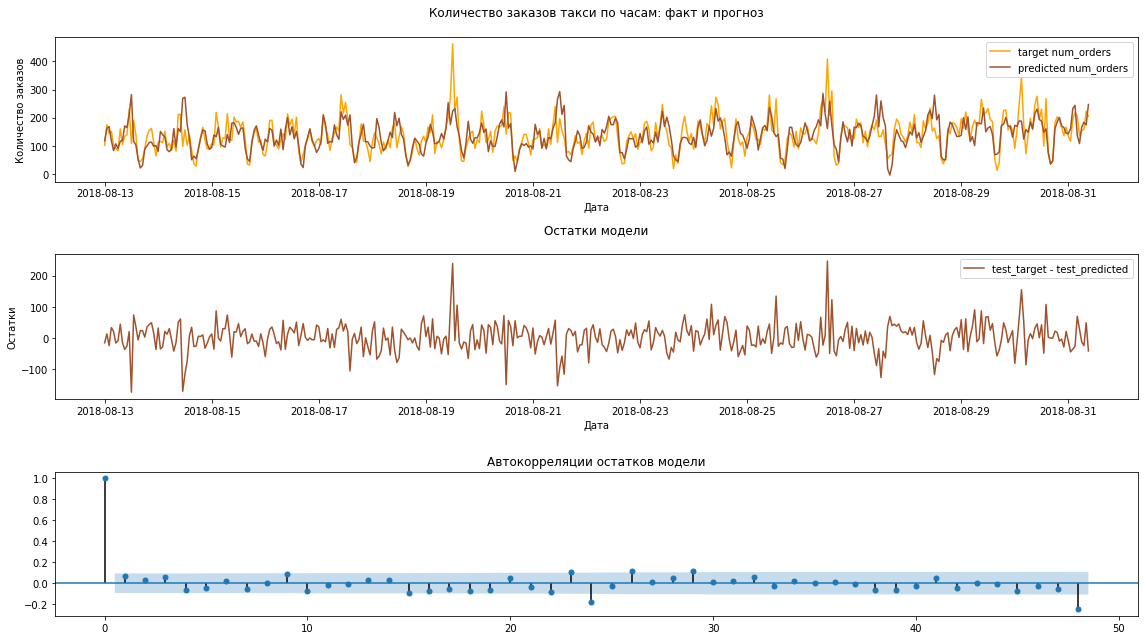

In [38]:
fig = plt.figure(figsize=(16,9))

# линейный график для таргета и предсказаний
ax = plt.subplot(311)
# таргет
fun_ax(ax, 'plot', test_target,
       'Количество заказов такси по часам за весь период\n',
       x_label='Дата', y_label='Количество заказов',
       color='orange', label='target num_orders',
       xtick_location=test_target.index.tolist()[::48])
# предсказания
fun_ax(ax, 'plot', pd.Series(best_predictions, index=test_target.index),
       'Количество заказов такси по часам: факт и прогноз\n',
       x_label='Дата', y_label='Количество заказов',
       color='sienna', label='predicted num_orders')

# линейный график для остатков модели
ax = plt.subplot(312)
fun_ax(ax, 'plot',
       pd.Series(model_resid, index=test_target.index),
       'Остатки модели\n', x_label='Дата', y_label='Остатки',
       color='sienna', label='test_target - test_predicted',
       xtick_location=test_target.index.tolist()[::48])

# ACF для остатков модели
ax = plt.subplot(313)
fun_acf_pcf(ax, test_target.values - best_predictions, 48, 'acf', 'Автокорреляции остатков модели')

fig.tight_layout()

# сохраняем значения автокорреляций остатков модели
q_test = sm.tsa.stattools.acf(model_resid, qstat=True) 

### Проверим остатки на стационарность с помощью критерия Дики-Фуллера

In [39]:
# критерий Дики-Фуллера
fun_adfuller(model_resid, 'Остатки модели')

H0: Ряд нестационарен
H1: Ряд стационарен

Критерий Дики-Фуллера для ряда Остатки модели
statistic=-19.605, p=0.0000000

Отклоняем H0. Принимаем H1:
Ряд стационарен


###  Проверим остатки на равенство среднего нулю с помощью t-критерий Стьюдента

In [40]:
# t-test на равенство среднего нулю
fun_ttest(model_resid, 'Остатки модели')

H0: Среднее ГС, из которой взята выборка, равно 0
H1: Среднее ГС, из которой взята выборка, НЕ равно 0

Критерий t-Стьюдента для выборки Остатки модели
statistic=0.951, p=0.3422430

У нас недостаточно оснований отклонить H0:
Среднее ГС, из которой взята выборка, равно 0


### Проверим автокорреляции остатков на равенство среднего нулю с помощью t-критерий Стьюдента

In [41]:
# t-test на равенство среднего нулю
fun_ttest(q_test[0], 'Автокорреляции остатков модели')

H0: Среднее ГС, из которой взята выборка, равно 0
H1: Среднее ГС, из которой взята выборка, НЕ равно 0

Критерий t-Стьюдента для выборки Автокорреляции остатков модели
statistic=0.710, p=0.4817689

У нас недостаточно оснований отклонить H0:
Среднее ГС, из которой взята выборка, равно 0


### Вывод:
 - В качестве лучшей модели выбрали модель Линейная регрессия
 - Провели анализ остатков модели Линейная регрессия. По линейному графику остатков видим, что *остатки похожи на белый шум*
 - **Остатки являются**:
      1. **стационарными** (что подтверждает Критерий Дики-Фуллера)
      2. **несмещенными**, то есть в среднем равны 0 (что подтверждает t-критерий Стьюдента о равенстве среднего нулю)
      2. **неавтокоррелированными** (что подтверждает t-критерий Стьюдента о равенстве среднего нулю, а также отсутствие на коррелограмме значимых лагов)

<a id='Link16'></a>

## 8. Сделам прогноз ряда на новые 24 часа вперед

In [42]:
def fun_forecast_new_hour(model, new_features, time_label, df):
    """функция для прогнозирования значения ряда на следующий час
    записывает в датасет признаки для модели,
    делает предсказания,
    записывает прогноз в датасет для дальнейшего прогнозирования следующих часов
    
    параметры: модель, список признаков,
               индекс новой строки (datetime), датасет
    возвращает датасет с новой строкой
    """
    
    # предсказания дифференцированного ряда
    predicted_diffs = model.predict([new_features])
    
    # создаем новую строку в датасете и записываем признаки
    df.loc[time_label] = new_features

    # предсказания исходного ряда после обратного дифференцирования
    predictions = predicted_diffs + df.iloc[-DIFF_LAG-1]['num_orders'] 
 
    # записвыаем в датасет предсказанные значения дифференцированного и исходного рядов
    df.loc[time_label]['num_orders'] = predictions
    df.loc[time_label]['num_orders_diff'] = predicted_diffs
    
    # возвращаем датасет с новой строкой
    return df

In [43]:
# создаем датасет - копию taxi, в который будем добавлять новые предсказания
taxi_with_forecast = taxi.copy()

# продолжим ряд, предскажем следующие 24 часа
forecast_horizon = 24

# индекс строки для нового часа - это последний индекс из нашего ряда + 1 час
time_label = taxi_with_forecast.iloc[-1].name + pd.to_timedelta('1 hour')

# в цикле для каждого нового часа создаем признаки и предсказываем
for forecast_hour in range(1,forecast_horizon+1):

    # создаем признаки для нового часа
    new_row = fun_create_features_new_row(taxi_with_forecast, MAX_LAG, ROL_SIZE, time_label)
    
    # делаем предсказания для нового часа и записываем их в строку для нового часа,
    # чтобы далее эти предсказания использовать для предсказаний следующих часов
    taxi_with_forecast = fun_forecast_new_hour(best_model, new_row, time_label, taxi_with_forecast)

    # увеличиваем индекс на 1 час
    time_label = pd.to_datetime(time_label) + pd.to_timedelta('1 hour')

### Построим линейный график для нашего ряда и полученного прогноза на следующие 24 часа

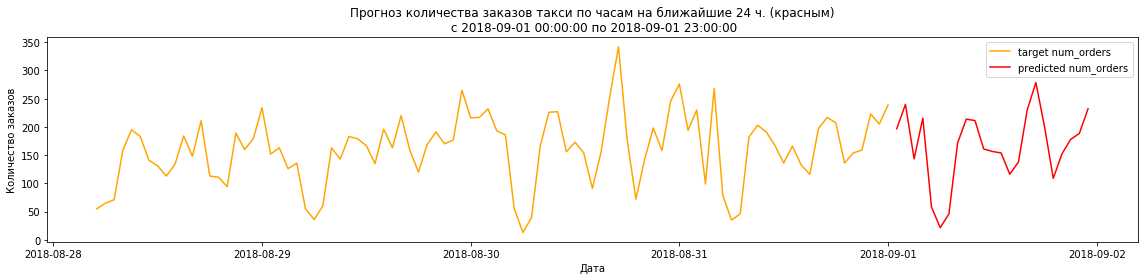

In [44]:
fig = plt.figure(figsize=(16,4))

# линейный график для исходного ряда и предсказаний
ax = plt.subplot(111)

# значение исходного ряда
fun_ax(ax, 'plot', taxi_with_forecast[(-forecast_horizon + 1)*5:-forecast_horizon + 1].num_orders,
       '', color='orange', label='target num_orders')
# прогноз
fun_ax(ax, 'plot', taxi_with_forecast[-forecast_horizon + 1:].num_orders,
       'Прогноз количества заказов такси по часам на ближайшие {} ч. (красным)\n с {} по {}'.
       format(forecast_horizon,
              time_label - pd.to_timedelta('{} hour'.format(forecast_horizon)),
              time_label - pd.to_timedelta('1 hour')),
       x_label='Дата', y_label='Количество заказов',
       color='red', label='predicted num_orders')

fig.tight_layout()

### Вывод:
 - Визуально наш прогноз (красным цветом) выглядит адекватно

<a id='Link17'></a>

## 9. Общий вывод


- *Изучили общую информацию*
 - Отметили, что величина количества заказов фиксируется каждые 10 минут


- *Предобработали данные*
 - Отсортировали временной ряд по индексу и провели **ресемплирование данных с шагом в 1 час**


- *Провели исследовательский анализ данных*
 - Построили boxplot'ы и гистограммы. Обнаружили:
      - Выбросы от 186 заказов в час
      - Грубые выбросы от 266 заказов в час
 - Построили графики **временного ряда, тренда и сезонности**. Отметили:
      - **Восходящий тренд**: с марта 2018 по сентябрь 2018 количество заказов в час постепенно увеличивалось
      - Каждую ночь до раннего утра количество заказов такси падает, больше всего заказов вечером (**суточная сезонность**)
 - **Изучили автокорреляции ряда**. Отметили:
      - Высокую корреляцию между заказами такси с лагом в 24 часа (что ещё раз подтвердило суточную сезонность) и между соседними часами
      - Автокорреляции значимо отличаются от нуля
 - Провели **дифференцирование ряда на сезонный лаг**. Получили стационарный ряд без тренда с автокорреляциями, значимо не отличающимися от нуля
      

- *Подготовили признаки для построения модели*
 - Создали новые признаки:
     - *Календарные признаки*: `hour` и `dayofweek`
     - *Отстающие значения*: лаги за последние сутки (24 часа)
     - *Скользящее среднее*: за последние 3 часа
 - Разделили датасет на обучающую и тестовую (10% от исходных данных) выборки


- *Построили модели:* **Линейная регрессия, Дерево решений, Случайный лес, Градиентный бустинг**


- *Провели анализ моделей*
 - Проверили модели на тестовой выборке
 - Проверили модели на вменяемость. Все модели прошли проверку на вменяемость.
 - Получили модели с метрикой **RMSE** на тестовой выборке **не больше 48**:
     - **Линейная регрессия: RMSE = 45.58**
     - **Случайный лес: RMSE = 47.54**
     - **Градиентный бустинг: RMSE = 47.57**
 - Самой **лучшей** моделью по качеству оказалась **Линейная регрессия**


- Выбрали лучшую модель - Линейная регрессия. Провели анализ остатков модели. *Остатки* оказались:
    - *стационарными*
    - *несмещенными*
    - *неавтокоррелированными*


- Сделали прогноз ряда на следующие 24 часа вперед 


- **Вывод**
 - *Самой лучшей моделью* оказалась модель **Линейная регрессия**. Анализ остатков модели доказал, что модель взяла из данных максимум информации.

 
 - **Рекомендуем компании такси для прогнозирования количества заказов такси на следующий час в аэропортах модель Линейная регрессия**